In [74]:
import sys,os
import uproot4 as uproot
import awkward1 as ak
import pandas as pd
import json
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from fcc_python_tools.locations import loc
from fcc_python_tools import kinematics
from particle import literals as lp
from fcc_python_tools import plotting

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

In [56]:
sample_names = {"mumu": "\\mu\\mu",
               "ee": "ee",
               "bbbar": "b\\bar{b}",
               "ccbar": "c\\bar{c}",
               "qqbar": "q\\bar{q}"
              }

sample = "bbbar"
sample_name = sample_names[sample]
file = uproot.open(f"/eos/experiment/fcc/ee/tmp/ee_Z_{sample}_EDM4Hep.root")
tree = file['events']
n = tree.num_entries
vars = tree.keys()

In [57]:
p_container = "ReconstructedParticles"
p_c = f'{p_container}/{p_container}'

#Don't keep the covMatrix
keep_vars = []
for v in vars:
    if("covMatrix" not in v and p_c in v):
        keep_vars.append(v)

p = tree.arrays(keep_vars,how="zip")
p[p_c,'p'] = kinematics.calc_p(p,p_c)
p[p_c,'pt'] = kinematics.calc_pt(p,p_c)
p[p_c,'theta'] = kinematics.calc_theta(p,p_c)

In [58]:
#Loacation of the tracks
t_container = "EFlowTrack_1"
t_c = f'{t_container}/{t_container}'

#Keep the covMatrix
keep_vars = []
for v in vars:
    if("covMatrix" in v and t_c in v):
        keep_vars.append(v)

t_cov = tree.arrays(keep_vars,how="zip")

#Keep everything apart from covMatrix
keep_vars = []
for v in vars:
    if("covMatrix" not in v and t_c in v):
        keep_vars.append(v)

t = tree.arrays(keep_vars,how="zip")

Loop over events and reco particles in each event. Find the track associated to the reco particle (if there is one), and store to a dict. Only consider the reco particles with $p > 500$ MeV and $\theta > 0.175$ rad (10 degrees).

In [59]:
dict = {}

for i in range(0,n):
    #Number of reco particles in the event
    n_p = ak.num(p[p_c])[i]
    
    #Number of tracks
    n_t = ak.num(t[t_c])[i]
    
    #Loop over the reco particles
    for j in range(0,n_p):
        
        if(p[p_c,'tracks_begin'][i][j] < n_t):
            
            #Apply momentum and theta cuts
            if(p[p_c,'p'][i][j] > 0.5 and p[p_c,'theta'] > 0.175):
            
                #Track index
                track_index = p[p_c,'tracks_begin'][i][j]
                
                dict[f"{i}_{j}"] = {}
                
                #Dict associating track and particle
                dict[f"{i}_{j}"]["track"] = t[t_c][i][track_index]
                dict[f"{i}_{j}"]["track_cov"] = t_cov[t_c][i][track_index]
                dict[f"{i}_{j}"]["reco_particle"] = p[p_c][i][j]

For each IP variable, grab the IP and IP error values to plot a distribution of $\sigma(IP)/IP$.

In [60]:
#Location of the diagonal terms in the track covMatrix, which give the error on the IP values
IP = {"D0": 0,
      #"phi": 5,
      #"omega": 9,
      "Z0": 12,
      #"tanLambda": 14
     }

#IP values, errors, and particle momenta for each of the IP variables
IP_vals = {}
IP_errs = {}
p_vals = {}
pt_vals = {}

df = {}

#Loop over IP variable
for var in IP:
    
    df[var] = pd.DataFrame()
    
    #Loop over particle dict and get the values for each particle in each event
    IP_vals[var] = []
    IP_errs[var] = []
    p_vals[var] = []
    pt_vals[var] = []
    
    for particle in dict:
        #IP value from the track container
        IP_val = dict[particle]["track"][var]
        #Corresponding IP error from the track covariance matrix - location in matrix given by value in IP dict above
        IP_err = dict[particle]["track_cov"]["covMatrix[15]"][IP[var]]
        #Momentum value for particle
        p_val = dict[particle]["reco_particle"]["p"]
        pt_val = dict[particle]["reco_particle"]["pt"]
        
        IP_vals[var].append(IP_val)
        IP_errs[var].append(IP_err)
        p_vals[var].append(p_val)
        pt_vals[var].append(pt_val)
    
    df[var]["IP"] = IP_vals[var]
    df[var]["IP_err"] = IP_errs[var]
    df[var]["p"] = p_vals[var]
    df[var]["pt"] = pt_vals[var]

    df[var]["IP_per_err"] = 100*(df[var]["IP_err"]/df[var]["IP"])

Plot the IP resolutions

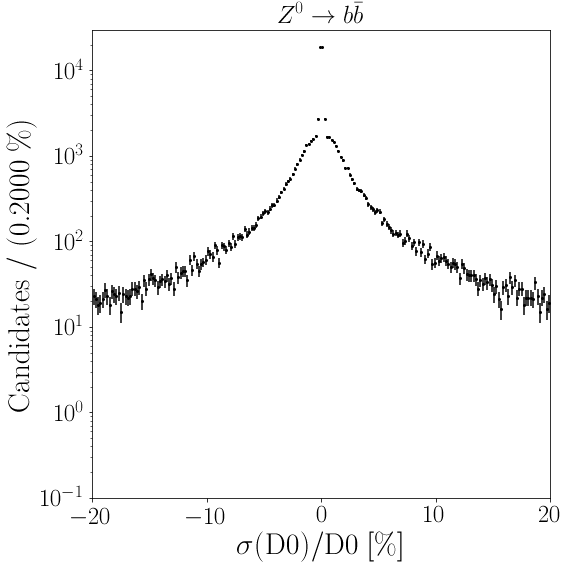

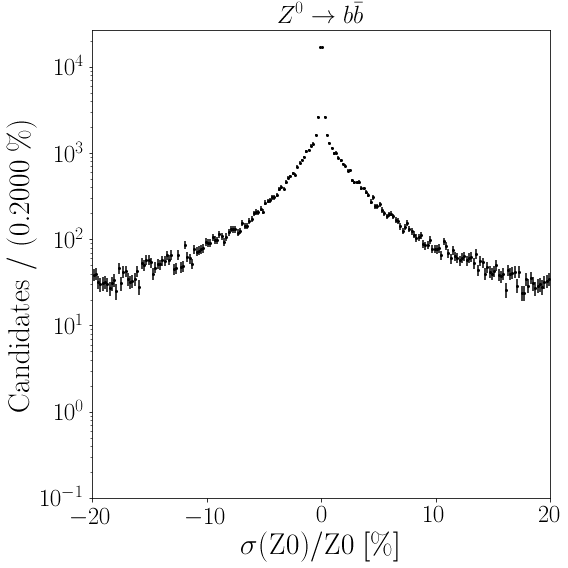

In [61]:
for var in IP:
    
    low = -20
    high = 20
    bins = 200
    log = True
    fig, ax = plt.subplots(figsize=(8,8))
    bin_w = (high - low)/bins
    var_name = var.replace("_","\_")
    counts, bin_edges = np.histogram(df[var]["IP_per_err"], bins, range=(low,high))
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
    err = np.sqrt(counts)
    plt.errorbar(bin_centres, counts, yerr=err, fmt='o', color='k', markersize=2)
    plt.xlabel(f"$\sigma$({var_name})/{var_name} [\%]",fontsize=30)
    plt.ylabel(f"Candidates / ({bin_w:.4f} \%)", fontsize=30)
    plt.xlim(low,high)
    ax.tick_params(axis='both', which='major', labelsize=25)
    ymin, ymax = plt.ylim()
    if(log==True):
        plt.yscale('log')
        plt.ylim(0.1,ymax*1.5)
    else:
        plt.ylim(0.,ymax*1.1)
    plt.title("$Z^0 \\to %s$" % sample_name,fontsize=25)
    plt.tight_layout()
    plt.show()
    fig.savefig(f"{loc.PLOTS}/{sample}_{var}_IP_res_per.pdf")

Plot the IP resolutions as a function of $1/p_T$

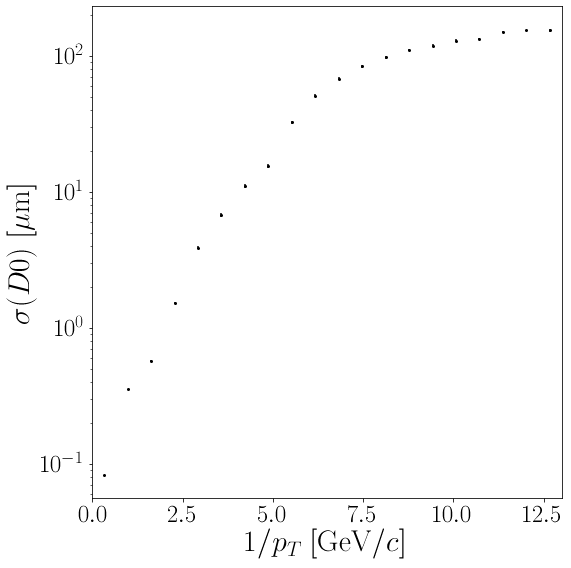

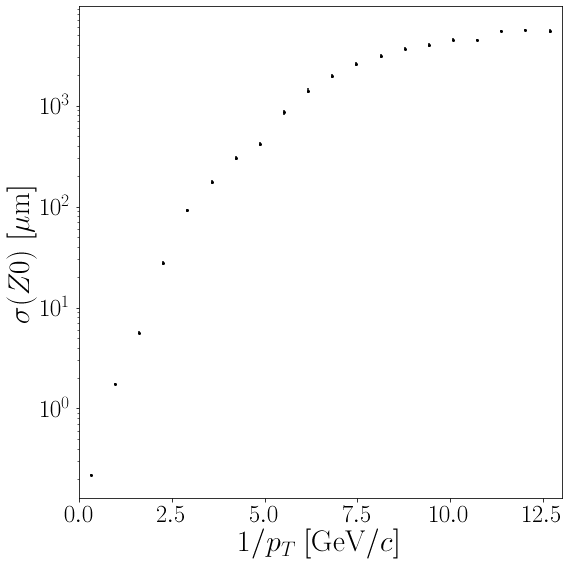

In [94]:
inv_pt_min = 0.
inv_pt_max = 13.
n_bins = 21
inv_pt_range = np.linspace(inv_pt_min,inv_pt_max,n_bins)

for var in IP:
    df[var]["inv_pt"] = 1.0/df[var]["pt"]
    
    inv_pt_vals = []
    mean_IP_err_vals = []
    mean_IP_err_sem_vals = []
    
    for i in range(0,len(inv_pt_range)-1):
        #Keep particles in a given bin of 1/pT
        df_cut = df[var].query(f"inv_pt > {inv_pt_range[i]} and inv_pt <= {inv_pt_range[i+1]}")
        bin_centre = inv_pt_range[i] + 0.5*(inv_pt_range[i+1] - inv_pt_range[i])
        inv_pt_vals.append(bin_centre)
        mean_IP_err_vals.append(1000*df_cut["IP_err"].mean())
        mean_IP_err_sem_vals.append(1000*stats.sem(df_cut["IP_err"]))
    
    fig,ax = plt.subplots(figsize=(8,8))
    plt.errorbar(inv_pt_vals, mean_IP_err_vals, mean_IP_err_sem_vals, fmt='o', markersize=2, color='k')
    ax.tick_params(axis='both', which='major', labelsize=25)
    plt.xlim(inv_pt_min, inv_pt_max)
    plt.yscale('log')
    plt.xlabel("$1/p_T$ [GeV/$c$]",fontsize=30)
    plt.ylabel(f"$\\sigma({var})$ [$\mu$m]",fontsize=30)
    plt.tight_layout()
    plt.show()